<a target="_blank" href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/rapids-pip-colab-template.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Install RAPIDS into Colab"/>
</a>

# RAPIDS cuDF is now already on your Colab instance!
RAPIDS cuDF is preinstalled on Google Colab and instantly accelerates Pandas with zero code changes. [You can quickly get started with our tutorial notebook](https://nvda.ws/rapids-cudf). This notebook template is for users who want to utilize the full suite of the RAPIDS libraries for their workflows on Colab.  

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

You can check the output of `!nvidia-smi` to check which GPU you have.  Please uncomment the cell below if you'd like to do that.  Currently, RAPIDS runs on all available Colab GPU instances.

In [1]:
# !nvidia-smi

#Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Pip Installs the RAPIDS' libraries, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuxFilter
  1. cuCIM
  1. xgboost

# Controlling Which RAPIDS Version is Installed
This line in the cell below, `!python rapidsai-csp-utils/colab/pip-install.py`, kicks off the RAPIDS installation script.  You can control the RAPIDS version installed by adding either `latest`, `nightlies` or the default/blank option.  Example:

`!python rapidsai-csp-utils/colab/pip-install.py <option>`

You can now tell the script to install:
1. **RAPIDS + Colab Default Version**, by leaving the install script option blank (or giving an invalid option), adds the rest of the RAPIDS libraries to the RAPIDS cuDF library preinstalled on Colab.  **This is the default and recommended version.**  Example: `!python rapidsai-csp-utils/colab/pip-install.py`
1. **Latest known working RAPIDS stable version**, by using the option `latest` upgrades all RAPIDS labraries to the latest working RAPIDS stable version.  Usually early access for future RAPIDS+Colab functionality - some functionality may not work, but can be same as the default version. Example: `!python rapidsai-csp-utils/colab/pip-install.py latest`
1. **the current nightlies version**, by using the option, `nightlies`, installs current RAPIDS nightlies version.  For RAPIDS Developer use - **not recommended/untested**.  Example: `!python rapidsai-csp-utils/colab/pip-install.py nightlies`


**This will complete in about 5-6 minutes**

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 1017.00 KiB/s, done.
Resolving deltas: 100% (299/299), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Resolved 173 packages in 1.67s
 Downloaded cuproj-cu12
 Downloaded cudf-cu12
 Downloaded shapely
 Downloaded ucx-py-cu12
 Downloaded datashader
 Downloaded dask
 Downloaded libkvikio-cu12
 Downloaded pylibcugraph-cu12
 Downloaded rmm-cu12
 Downloaded bokeh
 Downloaded cugraph-cu12
 Downloaded cuspatial-cu12
 Downloaded librmm-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded libraft-cu12
 Downloaded pylibcudf-cu12
 Downloaded libcudf-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libc

# RAPIDS is now installed on Colab.  
You can copy your code into the cells below or use the below to validate your RAPIDS installation and version.  
# Enjoy!

In [3]:
import cudf
cudf.__version__

'25.04.00'

In [4]:
import cuml
cuml.__version__

'25.04.00'

In [5]:
import cugraph
cugraph.__version__

'25.04.01'

In [6]:
import cuspatial
cuspatial.__version__

'25.04.00'

In [7]:
import cuxfilter
cuxfilter.__version__

'25.04.00'

# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

In [13]:
import networkx as nx
# from neulay import NeuLay
import time
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
def load_test_graphs():
    """
    Generate or load a set of test graphs of increasing size.
    Here we use Erdos-Renyi random graphs as examples.
    Returns a dict: {name: NetworkX Graph}
    """
    sizes = [1000, 5000, 10000]
    graphs = {}
    for n in sizes:
        p = min(10/n, 0.01)
        G = nx.erdos_renyi_graph(n, p, seed=42)
        graphs[f"ER_{n}"] = G
    return graphs

In [15]:
def benchmark_cpu_force(G):
    start = time.perf_counter()
    pos = nx.spring_layout(G)
    return time.perf_counter() - start


def benchmark_gpu_force(G, barnes_hut=False):
    # Convert NetworkX graph to cuGraph
    df_edges = cudf.DataFrame({
        'src': [u for u, v in G.edges()],
        'dst': [v for u, v in G.edges()]
    })
    cg = cugraph.Graph()
    cg.from_cudf_edgelist(df_edges, source='src', destination='dst', renumber=False)

    start = time.perf_counter()
    df_pos = cugraph.force_atlas2(
        cg,
        jitter_tolerance=0.05,
        barnes_hut_optimize=barnes_hut,
        max_iter=200
    )
    return time.perf_counter() - start

In [16]:
graphs = load_test_graphs()
results = []
for name, G in graphs.items():
    t_cpu = benchmark_cpu_force(G)
    t_gpu = benchmark_gpu_force(G, barnes_hut=False)
    t_gpu_bh = benchmark_gpu_force(G, barnes_hut=True)
    # t_neulay = benchmark_neulay(G)
    for method, t in [
        ("CPU_FR", t_cpu),
        ("GPU_FR", t_gpu),
        ("GPU_BH", t_gpu_bh),
        # ("NeuLay", t_neulay)
    ]:
        results.append({"graph": name, "method": method, "time_s": t})

# Create DataFrame
df = pd.DataFrame(results)

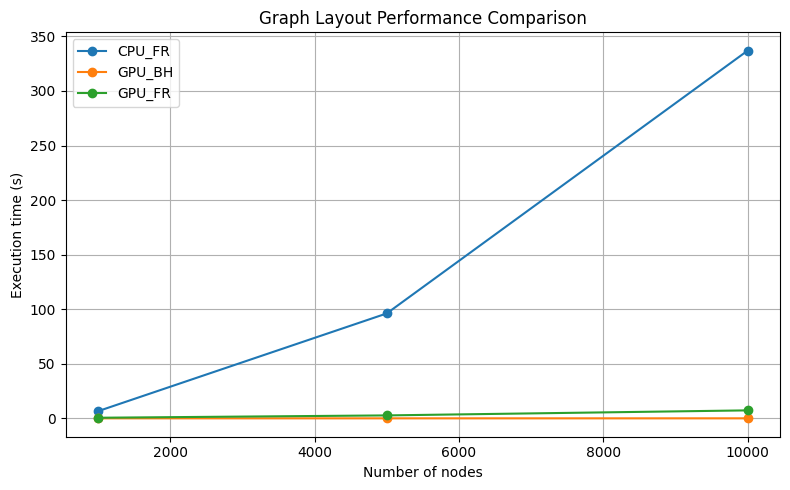

In [17]:
plt.figure(figsize=(8, 5))
for method, grp in df.groupby('method'):
    sizes = [int(g.split('_')[1]) for g in grp['graph']]
    plt.plot(sizes, grp['time_s'], marker='o', label=method)

plt.xlabel('Number of nodes')
plt.ylabel('Execution time (s)')
plt.title('Graph Layout Performance Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()